In [25]:
import os
import csv
import time
import logging
import uuid

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve


tf.get_logger().setLevel('ERROR')

Dataset: frag_bass_ntm.csv and NLReff.csv
Predicting batch 1 of 13
Batch time: 34.17 seconds. Elapsed time: 34.17 seconds. Estimated time remaining: 410.05 seconds.
Predicting batch 2 of 13
Batch time: 32.56 seconds. Elapsed time: 66.73 seconds. Estimated time remaining: 358.17 seconds.
Predicting batch 3 of 13
Batch time: 30.16 seconds. Elapsed time: 96.90 seconds. Estimated time remaining: 301.64 seconds.
Predicting batch 4 of 13
Batch time: 31.75 seconds. Elapsed time: 128.65 seconds. Estimated time remaining: 285.77 seconds.
Predicting batch 5 of 13
Batch time: 31.50 seconds. Elapsed time: 160.15 seconds. Estimated time remaining: 252.00 seconds.
Predicting batch 6 of 13
Batch time: 31.12 seconds. Elapsed time: 191.27 seconds. Estimated time remaining: 217.82 seconds.
Predicting batch 7 of 13
Batch time: 30.18 seconds. Elapsed time: 221.45 seconds. Estimated time remaining: 181.10 seconds.
Predicting batch 8 of 13
Batch time: 30.01 seconds. Elapsed time: 251.46 seconds. Estimated t

KeyboardInterrupt: 

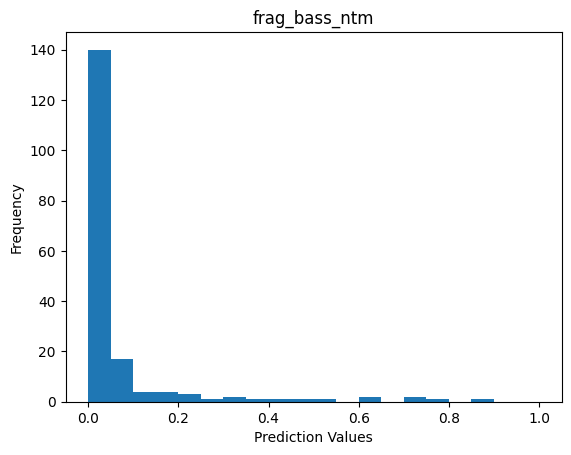

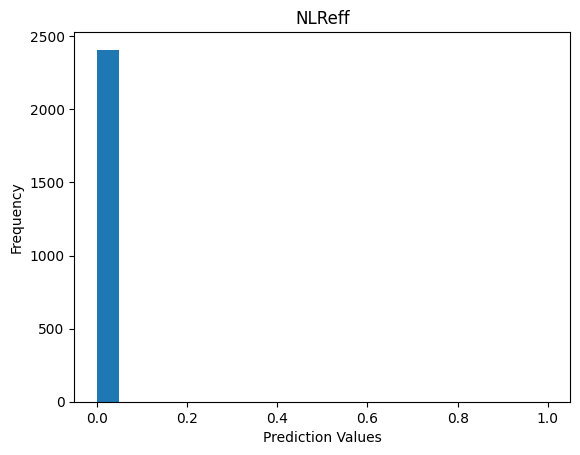

In [31]:
# Constants
ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
ADDITIONAL_TOKENS = ['<OTHER>', '<START>', '<END>', '<PAD>']
ADDED_TOKENS_PER_SEQ = 2
MODEL_PATH = './proteinbert_models/proteinBERT_full/1'
DATA_PATH = './test_sets/'
DATASET_PATH = 'bass_other_nlreff.csv'
SEQ_LENGTH = 42
SEQ_CUTOFF = 39

# Preprocessing 
n_aas = len(ALL_AAS)
aa_to_token_index = {aa: i for i, aa in enumerate(ALL_AAS)}
additional_token_to_index = {token: i + n_aas for i, token in enumerate(ADDITIONAL_TOKENS)}
token_to_index = {**aa_to_token_index, **additional_token_to_index}
index_to_token = {index: token for token, index in token_to_index.items()}
n_tokens = len(token_to_index)

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

def parse_seq(seq):
    """Decodes sequence if it is in bytes"""
    if isinstance(seq, str):
        return seq
    elif isinstance(seq, bytes):
        return seq.decode('utf8')
    else:
        raise TypeError('Unexpected sequence type: %s' % type(seq))

def tokenize_seq(seq):
    """Converts sequence of amino acids into a list of token indices."""
    other_token_index = additional_token_to_index['<OTHER>']
    return [additional_token_to_index['<START>']] + [aa_to_token_index.get(aa, other_token_index) for aa in parse_seq(seq)] + [additional_token_to_index['<END>']]

def tokenize_seqs(seqs, seq_len):
    """Converts list of sequences into array of token indices."""
    return np.array([seq_tokens + (seq_len - len(seq_tokens)) * [additional_token_to_index['<PAD>']] for seq_tokens in map(tokenize_seq, seqs)], dtype = np.int32)


def load_data(data_path):
    """Loads sequences from a CSV file."""
    df = pd.read_csv(data_path)
    labels = df['label']
    sequences = df['seq']
    return labels, sequences

def compute_metrics(y_true, y_scores, fprs):
    """Compute AUROC, average precision, and recall at specified FPRs."""
    # AUROC and average precision
    auroc = roc_auc_score(y_true, y_scores)
    avg_prec = average_precision_score(y_true, y_scores)
    
    # Precision and recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute recall (TPR) at specified FPRs
    recall_at_fprs = []
    for desired_fpr in fprs:
        # Find the TPR for this FPR
        # We're looking for the first threshold that gives a FPR <= our desired FPR
        try:
            threshold_index = next(i for i, current_fpr in enumerate(fpr) if current_fpr >= desired_fpr)
            recall_at_fprs.append(tpr[threshold_index])
        except StopIteration:
            recall_at_fprs.append(0.0)

    return auroc, avg_prec, recall_at_fprs


def predict_window(sequences, seq_cutoff=SEQ_CUTOFF, batch_size=200):
    """Predicts model output for a window in the sequence and return list of predictions."""
    all_predictions = []
    num_batches = len(sequences) // batch_size + (len(sequences) % batch_size != 0)  # Adding 1 if there's a remainder
    start_time = time.time()
    for i in range(0, len(sequences), batch_size):
        batch_start_time = time.time()
        print(f"Predicting batch {i//batch_size + 1} of {num_batches}")
        batch_sequences = sequences[i:i+batch_size]
        for seq in batch_sequences:
            batch_subsequences = [seq[i:seq_cutoff+i+1] for i in range(len(seq)-seq_cutoff)]
            if batch_subsequences == []:
                batch_subsequences = [seq]
            preds = model.predict([tokenize_seqs(batch_subsequences, SEQ_LENGTH), np.zeros((len(batch_subsequences), 8943), dtype=np.int8)], verbose=0)
            # Flattening the predictions and extending all_predictions list
            flattened_preds = [pred[0] for pred in preds]
            max_pred = np.max(flattened_preds)
            all_predictions.append(max_pred)
        batch_end_time = time.time()
        batch_time = batch_end_time - batch_start_time
        elapsed_time = time.time() - start_time
        estimated_time_remaining = batch_time * (num_batches - (i // batch_size + 1))
        print(f"Batch time: {batch_time:.2f} seconds. Elapsed time: {elapsed_time:.2f} seconds. Estimated time remaining: {estimated_time_remaining:.2f} seconds.")
    return all_predictions

def plot_histogram(predictions, name):
    """Generates and shows a histogram plot of prediction values."""
    plt.hist(predictions, bins=np.arange(0, 1.05, 0.05))
    plt.xlabel('Prediction Values')
    plt.ylabel('Frequency')
    plt.title(name)

def get_dataset_pairs():
    """Gets all pairs of positive and negative sets in a given folder."""
    files = os.listdir(DATA_PATH)
    negative_sets = [f for f in files if '_' not in f]
    positive_sets = [f for f in files if '_' in f]
    pairs = [(pos, neg) for pos in positive_sets for neg in negative_sets]
    return pairs

def main(dataset_path_pos, dataset_path_neg, predictions_cache):
    """Main function to execute the script."""
    labels_pos, sequences_pos = load_data(DATA_PATH + dataset_path_pos)
    labels_neg, sequences_neg = load_data(DATA_PATH + dataset_path_neg)
    

    fprs = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    print(f"Dataset: {dataset_path_pos} and {dataset_path_neg}")

    # Check if predictions are already calculated and cached for negative dataset
    if dataset_path_neg in predictions_cache:
        print("Using cached predictions for ", dataset_path_neg)
        y_scores_neg = predictions_cache[dataset_path_neg]
    else:
        y_scores_neg = predict_window(sequences_neg)
        predictions_cache[dataset_path_neg] = y_scores_neg  # cache the predictions

    # Check if predictions are already calculated and cached for positive dataset
    if dataset_path_pos in predictions_cache:
        print("Using cached predictions for ", dataset_path_pos)
        y_scores_pos = predictions_cache[dataset_path_pos]
    else:
        y_scores_pos = predict_window(sequences_pos)
        predictions_cache[dataset_path_pos] = y_scores_pos  # cache the predictions

    labels = pd.concat([labels_pos, labels_neg])
    y_scores = pd.concat([pd.Series(y_scores_pos), pd.Series(y_scores_neg)])
    

    dataset_path_pos_clean = dataset_path_pos.replace('.csv', '')
    dataset_path_neg_clean = dataset_path_neg.replace('.csv', '')

    plt.figure()
    plot_histogram(y_scores_pos, dataset_path_pos_clean)
    plt.savefig(dataset_path_pos_clean + '_histogram.png')

    plt.figure()
    plot_histogram(y_scores_neg, dataset_path_neg_clean)
    plt.savefig(dataset_path_neg_clean + '_histogram.png')

    auroc, avg_prec, recall_at_fprs = compute_metrics(labels, y_scores, fprs)

    # Open CSV file
    with open(f'results_{dataset_path_pos_clean}_{dataset_path_neg_clean}.csv', 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write the header
        csv_writer.writerow(['Model', '#pos', '#neg', 'AUROC', 'AP', 'Rc|FPR1e-1', 'Rc|FPR1e-2', 'Rc|FPR1e-3', 'Rc|FPR1e-4', 'Rc|FPR1e-5'])
        # Write results to CSV file
        row = [MODEL_PATH, len(labels_pos), len(labels_neg), auroc, avg_prec] + list(recall_at_fprs)
        csv_writer.writerow(row)

if __name__ == "__main__":
    pairs = get_dataset_pairs()
    predictions_cache = {}  # dictionary to store cached predictions
    for pos, neg in pairs:
        main(pos, neg, predictions_cache)
